# Trabajo Practico 2 - Sistemas Complejos

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Importacion de redes 

In [2]:
G_APMS = nx.read_edgelist('yeast_AP-MS.txt')
G_Y2H = nx.read_edgelist('yeast_Y2H.txt')
G_LIT = nx.read_edgelist('yeast_LIT.txt')

G_LIT_Reguly = nx.Graph()
data_lit_reguly = np.genfromtxt("yeast_LIT_Reguly.txt",dtype='unicode',delimiter = '\t')
yeast_LIT_Reguly_raw = [data_lit_reguly[1:,0],data_lit_reguly[1:,1]]

i=1
while i<len(data_lit_reguly[1:,0]):
    G_LIT_Reguly.add_edge(data_lit_reguly[i,0],data_lit_reguly[i,1])
    i+=1

Caracteristicas basicas de la red

In [3]:
def caracteristicas_basicas(G):
    numero_nodos = G.number_of_nodes()
    numero_enlaces = G.number_of_edges()
    grado_medio = np.round(np.true_divide(numero_enlaces,numero_nodos),2)
    average_clustering_coeficient = round(nx.average_clustering(G),2)
    resultado=[numero_nodos,numero_enlaces,grado_medio,average_clustering_coeficient]
    return resultado


Procesamiento de caracteristicas basicas de todas las redes

In [4]:
resultado_apms = caracteristicas_basicas(G_APMS)
resultado_y2h = caracteristicas_basicas(G_Y2H)
resultado_lit = caracteristicas_basicas(G_LIT)
resultado_lit_reguly = caracteristicas_basicas(G_LIT_Reguly)

In [5]:
data = pd.DataFrame({" ":["AP/MS",'Y2H','LIT','LIT-Reguly'],
                     "Number of Nodes":[resultado_apms[0],resultado_y2h[0],resultado_lit[0],resultado_lit_reguly[0]],
                     "Number of Edges":[resultado_apms[1],resultado_y2h[1],resultado_lit[1],resultado_lit_reguly[1]],
                     "Average degree":[resultado_apms[2],resultado_y2h[2],resultado_lit[2],resultado_lit_reguly[2]],
                     "Average clustering coefficient":[resultado_apms[3],resultado_y2h[3],resultado_lit[3],resultado_lit_reguly[3]]
                    })
data



,,Average clustering coefficient,Average degree,Number of Edges,Number of Nodes
0,AP/MS,0.55,5.59,9070,1622
1,Y2H,0.05,1.45,2930,2018
2,LIT,0.29,1.90,2925,1536
3,LIT-Reguly,0.26,3.59,11857,3307


Superposición de dos redes

La siguiente función remueve los nodos de la primera red que no estan en la segunda red. 

In [6]:
def intersection(red1,red2):
    red_interseccion = nx.intersection(red1,red2)
    
    resultado = red_interseccion.number_of_edges()
    return resultado


In [7]:
def superposicion(red1,red2):
    copia_red1=red1.copy()
    copia_red2=red2.copy()
    
    copia_red1.remove_nodes_from(n for n in red1 if n not in red2)
    copia_red2.remove_nodes_from(n for n in red2 if n not in red1)
    
    superposicion = intersection(copia_red1,copia_red2)
    return superposicion 


In [8]:
superposicion(G_Y2H,G_APMS)

260

In [9]:
def superposicion_redes(redes):
    i = 0
    l = len(redes)
    matriz_superposicion = np.zeros((l,l))
    while i < l:
        red_i = redes[i]
        j = i+1
        while j < l:
            red_j = redes[j]
            valor = superposicion(red_i,red_j)
            matriz_superposicion[i][j] = valor / red_i.number_of_edges()
            matriz_superposicion[j][i] = valor / red_j.number_of_edges()
            j+=1
        i+=1
    return matriz_superposicion

In [10]:
#Falta escribir bien la tabla
redes = [G_APMS,G_Y2H,G_LIT,G_LIT_Reguly]
superposicion_redes(redes)

array([[ 0.        ,  0.02866593,  0.14310915,  0.27783903],
       [ 0.0887372 ,  0.        ,  0.0887372 ,  0.16348123],
       [ 0.44376068,  0.08888889,  0.        ,  0.97777778],
       [ 0.21253268,  0.04039808,  0.24120773,  0.        ]])

In [11]:
G_ESSENTIAL = nx.Graph()
data_G_ESSENTIAL = np.genfromtxt("Essential_ORFs_paperHe.txt",dtype='unicode',delimiter = '\t')
yeast_G_ESSENTIAL_raw = [data_G_ESSENTIAL[2:,1]]

i = 0
l = len(yeast_G_ESSENTIAL_raw[0][:])

while i < l:
    proteina = yeast_G_ESSENTIAL_raw[0][i]
    yeast_G_ESSENTIAL_raw[0][i] = proteina.rstrip(" ")
    i+=1

In [12]:
# Le agregamos el atributo "genero" al grafo G

def agrega_esencialidad(red,lista_esencial):
    
    j = 0
    l = len(red)
    while j < l:
        nombre = list(red)[j]
        red.node[nombre]['esencialidad']=0
        j += 1
    
    for i in lista_esencial[0]:
        if (i in red):
            red.node[i]['esencialidad']=1
    return


In [80]:
agrega_esencialidad(G_APMS,yeast_G_ESSENTIAL_raw)
agrega_esencialidad(G_LIT,yeast_G_ESSENTIAL_raw)

Analisis de hubs

En primer lugar calculamos la distribución de grado

In [14]:
def maximo_grado(red):
    cantidad_nodos = red.number_of_nodes()
    maximo = 0
    i=0
    while i<cantidad_nodos:
        if list(red.degree)[i][1]>maximo:
            maximo = list(red.degree)[i][1]
        i+=1
    return maximo

In [62]:
def distribucion_grado(red):
    numero_nodos = red.number_of_nodes()
    l = len(red)
    m = maximo_grado(red)
    vector_nodos_esenciales= np.zeros(m+1)
    vector_grados= np.zeros(m+1)
    i = 0
    while i < l:
        grado = list(red.degree)[i][1]
        vector_grados[grado] += 1
        
        nombre = list(red)[i]
        esencialidad_nodo = red.node[nombre]['esencialidad']
        
        if (esencialidad_nodo==1):
            vector_nodos_esenciales[grado] += 1
        i+=1
    return (vector_grados,vector_nodos_esenciales)                        
    


In [74]:
hubs_APMS = distribucion_grado(G_APMS)

In [75]:
def hub_definition(hubs):
    vector_grados = hubs[0]
    vector_esencial = hubs[1]
    i = 1
    l = len(vector_grados)
    eje_x= np.zeros(l)
    eje_y= np.zeros(l)
    total_nodos = np.sum(vector_grados)
    while (i < l+1):
        eje_x[i-1]=np.sum(vector_grados[l-i:l])/(float(total_nodos))
        eje_y[i-1]=np.sum(vector_esencial[l-i:l])/np.sum(vector_grados[l-i:l])
        i+=1
        
    return(eje_x,eje_y)
        
        

In [76]:
eje_x = hub_definition(hubs_APMS)[0][:]
eje_y = hub_definition(hubs_APMS)[1][:]

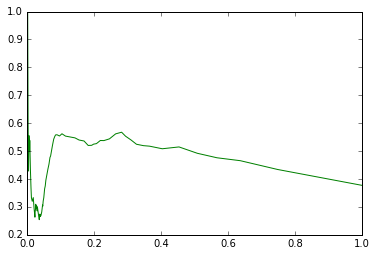

In [77]:
plt.plot(eje_x, eje_y, 'g-')
plt.show()

In [81]:
hubs_LIT = distribucion_grado(G_LIT)

In [82]:
eje_x = hub_definition(hubs_LIT)[0][:]
eje_y = hub_definition(hubs_LIT)[1][:]

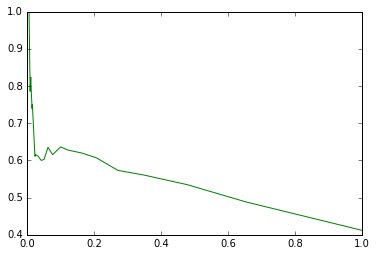

In [83]:
plt.plot(eje_x, eje_y, 'g-')
plt.show()

In [ ]:
'''
funcion_remove_random(red,umbral):
    #umbral = hasta donde llega el eje x
    copia_red
    inicilizar vectores para el grafico
    porcentaje = 0
    cantidad_maxima_nodos_removidos = umbral*cantidad_nodos
    for i=0:cantidad_maxima_nodos_removidos
        eje_x=[i/cantidad_nodos]
        copia_red = le quitamos un nodo al azar
        calculo = calcula_tamaño_comp_gigante(copia_red)/tamaño_componente_gigante_original
        
        eje_y+=[calculo]
    return(eje_x,eje_y)    
'''
